In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE 
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, plot_confusion_matrix, ConfusionMatrixDisplay

#### Complaints dataset from CFPB  
First, we load the dataset.  We use the file in the `shared\` folder.

In [2]:
# complaints = pd.read_csv(r"C:\Users\user\Downloads\complaints.csv")
# complaints = pd.read_csv(r'https://files.consumerfinance.gov/ccdb/complaints.csv.zip')
complaints = pd.read_csv('complaints.csv',low_memory=False)

##### Let us review the dataframe

In [3]:
complaints.shape

(118217, 18)

In [4]:
complaints.columns

Index(['Date received', 'Product', 'Sub-product', 'Issue', 'Sub-issue',
       'Consumer complaint narrative', 'Company public response', 'Company',
       'State', 'ZIP code', 'Tags', 'Consumer consent provided?',
       'Submitted via', 'Date sent to company', 'Company response to consumer',
       'Timely response?', 'Consumer disputed?', 'Complaint ID'],
      dtype='object')

In [5]:
complaints.Company.value_counts().sort_values(ascending=False).head(50)

BANK OF AMERICA, NATIONAL ASSOCIATION    30771
WELLS FARGO & COMPANY                    26521
JPMORGAN CHASE & CO.                     26454
CITIBANK, N.A.                           24662
U.S. BANCORP                              9809
Name: Company, dtype: int64

In [6]:
# Because the data is already pre-filtered to the top-5 companies, we do not need to run the below commands.

# banks = ['BANK OF AMERICA, NATIONAL ASSOCIATION', 'WELLS FARGO & COMPANY','JPMORGAN CHASE & CO.', 'CITIBANK, N.A.' , 'U.S. BANCORP']
# filtered = complaints[(complaints['Company'].isin(banks))]
# filtered.to_csv("complaints_14Nov21.csv", index=False)

In [7]:
complaints

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,12/1/2011,Credit card,NaN,Transaction issue,NaN,NaN,NaN,"BANK OF AMERICA, NATIONAL ASSOCIATION",IL,60540,NaN,NaN,Referral,12/1/2011,Closed with relief,Yes,No,2199
1,12/1/2011,Credit card,NaN,Credit reporting,NaN,NaN,NaN,WELLS FARGO & COMPANY,CO,80014,NaN,NaN,Referral,12/1/2011,Closed with relief,Yes,No,2214
2,12/1/2011,Mortgage,Other mortgage,"Application, originator, mortgage broker",NaN,NaN,NaN,"BANK OF AMERICA, NATIONAL ASSOCIATION",WI,54121,NaN,NaN,Web,12/2/2011,Closed without relief,No,Yes,2245
3,12/1/2011,Credit card,NaN,Identity theft / Fraud / Embezzlement,NaN,NaN,NaN,"CITIBANK, N.A.",NV,89415,NaN,NaN,Web,12/19/2011,Closed without relief,Yes,No,2240
4,12/2/2011,Credit card,NaN,Closing/Cancelling account,NaN,NaN,NaN,JPMORGAN CHASE & CO.,IL,60645,NaN,NaN,Referral,12/2/2011,Closed with relief,Yes,No,2452
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118212,11/26/2021,"Credit reporting, credit repair services, or o...",Other personal consumer report,Incorrect information on your report,Information belongs to someone else,NaN,Company has responded to the consumer and the ...,WELLS FARGO & COMPANY,GA,31211,NaN,NaN,Web,11/26/2021,Closed with explanation,Yes,NaN,4949952
118213,11/26/2021,Debt collection,Auto debt,Took or threatened to take negative or legal a...,Seized or attempted to seize your property,NaN,Company has responded to the consumer and the ...,WELLS FARGO & COMPANY,VA,20155,NaN,NaN,Web,11/26/2021,Closed with explanation,Yes,NaN,4949965
118214,11/27/2021,Credit card or prepaid card,General-purpose credit card or charge card,Closing your account,Can't close your account,NaN,Company has responded to the consumer and the ...,"CITIBANK, N.A.",NY,10034,NaN,Consent not provided,Web,11/27/2021,Closed with explanation,Yes,NaN,4951295
118215,11/28/2021,Checking or savings account,Checking account,Problem with a lender or other company chargin...,Transaction was not authorized,NaN,Company has responded to the consumer and the ...,U.S. BANCORP,CA,91001,NaN,NaN,Web,11/28/2021,Closed with explanation,Yes,NaN,4953884


#### Let us look at our target column, 'Consumer Disputed'

In [8]:
complaints['Consumer disputed?'].value_counts()

No     16804
Yes     4319
Name: Consumer disputed?, dtype: int64

In [9]:
complaints['Consumer disputed?'].value_counts().sum()

21123

##### The above is only 209k records.  But we have 378k records in our dataset.  So the rest is NaN values, ie blank.  Let us check that.

In [10]:
complaints['Consumer disputed?'].isna().sum()

97094

##### It is a fair assumption to think that wherever we see a NaN, it means there is no dispute. That is also supported by the other fields in the data that indicate whether the customer was satisfied.  So we will change all `NaN` values to `No`.  This will allow us to use all the data for our analysis.

In [11]:
complaints['Consumer disputed?'].fillna('No', inplace=True)
complaints['Consumer disputed?'] = complaints['Consumer disputed?'].astype('category')

Now let us look at our split between disputed and not-disputed complaints.

In [12]:
complaints['Consumer disputed?'].value_counts()

No     113898
Yes      4319
Name: Consumer disputed?, dtype: int64

In [13]:
# same thing as a percentage...
complaints['Consumer disputed?'].value_counts() / (complaints['Consumer disputed?'].value_counts().sum())

No     0.963465
Yes    0.036535
Name: Consumer disputed?, dtype: float64

So we have an imbalanced dataset as only about 12% is in the `Yes` class.  This means we should consider rebalancing the training dataset using a technique such as SMOTE.  But we will do that after doing the train-test split.  But first, we need to think about what in our data should be the predictor variables, ie, what should be included as a feature in `X`.  

##### What should our feature set look like?  
To do that, let us look at the dataset again.  And refer to the data-dictionary in the Word document for the project.  

|Field name  |Description  |Can it be a feature?  |
|------------  |------------  |------------  |
|Date received  |The date the CFPB received the complaint. For example, “05/25/2013.”  |Not a feature  |
|Product  |The type of product the consumer identified in the complaint. For example, “Checking or savings account” or “Student loan.”  |Yes  |
|Sub-product  |The type of sub-product the consumer identified in the complaint. For example, “Checking account” or “Private student loan.”  |Yes  |
|Issue  |The issue the consumer identified in the complaint. For example, “Managing an account” or “Struggling to repay your loan.”  |Yes  |
|Sub-issue  |The sub-issue the consumer identified in the complaint. For example, “Deposits and withdrawals” or “Problem lowering your monthly payments.”  |Yes  |
|Consumer complaint narrative  |Consumer complaint narrative is the consumer-submitted description of “what happened” from the complaint. Consumers must opt-in to share their narrative. We will not publish the narrative unless the consumer consents, and consumers can opt-out at any time. The CFPB takes reasonable steps to scrub personal information from each complaint that could be used to identify the consumer.  |Maybe, if we can convert text to some vector form  |
|Company public response  |The company’s optional, public-facing response to a consumer’s complaint. Companies can choose to select a response from a pre-set list of options that will be posted on the public database. For example, “Company believes complaint is the result of an isolated error.”  |Yes  |
|Company  |The complaint is about this company. For example, “ABC Bank.”  |Yes  |
|State  |The state of the mailing address provided by the consumer.  |Yes  |
|ZIP code  |The mailing ZIP code provided by the consumer. This field may: i) include the first five digits of a ZIP code; ii) include the first three digits of a ZIP code (if the consumer consented to publication of their complaint narrative); or iii) be blank (if ZIP codes have been submitted with non-numeric values, if there are less than 20,000 people in a given ZIP code, or if the complaint has an address outside of the United States).  |Yes  |
|Tags  |Data that supports easier searching and sorting of complaints submitted by or on behalf of consumers. For example, complaints where the submitter reports the age of the consumer as 62 years or older are tagged “Older American.” Complaints submitted by or on behalf of a servicemember or the spouse or dependent of a servicemember are tagged “Servicemember.” Servicemember includes anyone who is active duty, National Guard, or Reservist, as well as anyone who previously served and is a veteran or retiree.  |Yes  |
|Consumer consent provided?  |Identifies whether the consumer opted in to publish their complaint narrative. We do not publish the narrative unless the consumer consents, and consumers can opt-out at any time.  |Yes  |
|Submitted via  |How the complaint was submitted to the CFPB. For example, “Web” or “Phone.”  |Yes  |
|Date sent to company  |The date the CFPB sent the complaint to the company.  |Not relevant  |
|Company response to consumer  |This is how the company responded. For example, “Closed with explanation.”  |Yes  |
|Timely response?  |Whether the company gave a timely response. For example, “Yes” or “No.”  |Yes  |
|Consumer disputed?  |Whether the consumer disputed the company’s response.  |This the Target  |
|Complaint ID  |The unique identification number for a complaint.  |Not a feature  |


To begin with, let us ignore the text contained in 'Consumer complaint narrative' and look at the rest of the features.  We can come back to this later.

In [14]:
X = complaints[[ 'Product', 'Sub-product', 'Issue', 'Sub-issue',
        'Company public response', 'Company',
       'State',  'Tags', 'Consumer consent provided?',
       'Submitted via',  'Company response to consumer',
       'Timely response?']]

In [15]:
# Let us check if we have any missing values in our reduced dataset X

print(len(X)) # Number of rows before dropna()
print(len(X.dropna())) # Number of rows after dropna() 

118217
6997


We see that there are no cells that have NAs any more after our operations above.  So it is safe to proceed.

In [16]:
# Next, we convert all the X observations into numbers
X = pd.get_dummies(X)

##### Let us get our y variable

In [17]:
y = complaints['Consumer disputed?']

But y contains text, and we need to have 0s and 1s.  We can try to use LabelEncoder to do that

In [18]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
y = le.fit_transform(complaints['Consumer disputed?'])
print(le.classes_)
print(le.inverse_transform(list(set(y))))
labels = dict(zip(list(set(y)), le.inverse_transform(list(set(y)))))
print("\nLabel mapping is:", labels)


['No' 'Yes']
['No' 'Yes']

Label mapping is: {0: 'No', 1: 'Yes'}


We have our `X` and `y` defined.  Now let us do the train-test split

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Let us look at what our train and test sets look like.

In [20]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(94573, 547)
(94573,)
(23644, 547)
(23644,)


Since we have an imbalanced dataset, we should try to do something to oversample the minority category.  Let us do that using SMOTE.

In [21]:
# from imblearn.over_sampling import SMOTE 
# smote = SMOTE()
# X_train, y_train = smote.fit_resample(X_train, y_train)

**Looks like SMOTE is computationally very heavy, and does not produce great results for our models.**  

But because we have a lot of data, we can actually try undersampling too.  Interestingly, undersampling gives us better results in the modeling section later on.  

In [22]:
from imblearn.under_sampling import RandomUnderSampler
undersampler = RandomUnderSampler()
X_train, y_train = undersampler.fit_resample(X_train, y_train)

In [23]:
y_train.sum()/len(y_train) #just checking that the '1' category is exactly 50% of the training set

0.5

In [24]:
print(X.shape)
print(X_train.shape)
print(X_test.shape)

(118217, 547)
(6880, 547)
(23644, 547)


**Now everything is set up, we have X_train, y_train, X_test, y_test and a perfectly balanced dataset.  We can now feed it to a model of our choice, and look at the results.**  

### Let us fit the model using XGBoost

In [25]:
# Fit the model
from xgboost import XGBClassifier

model_xgb = XGBClassifier(use_label_encoder=False, objective= 'binary:logistic')
model_xgb.fit(X_train, y_train)

[19:35:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=12,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [26]:
# Perform predictions, and store the results in a variable called 'pred'
pred = model_xgb.predict(X_test)

              precision    recall  f1-score   support

           0       1.00      0.86      0.93     22765
           1       0.21      0.98      0.35       879

    accuracy                           0.87     23644
   macro avg       0.61      0.92      0.64     23644
weighted avg       0.97      0.87      0.90     23644



C:\Users\dhruv\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


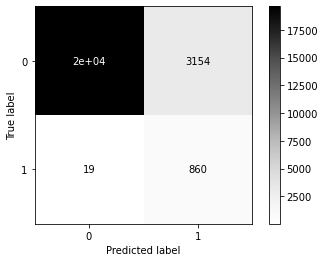

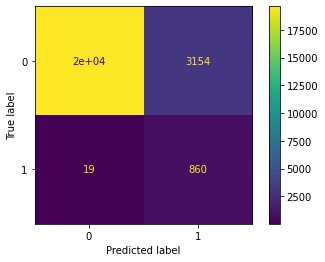

In [27]:
# Check the classification report and the confusion matrix
print(classification_report(y_true = y_test, y_pred = pred))
plot_confusion_matrix(model_xgb, X = X_test, y_true = y_test, cmap='Greys');

cm = confusion_matrix(y_test, pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()

**What should we do now?**  

We are able to obtain the probability for a complaint being a "1" (which means 'yes').  The default is generally 0.5, which means if the probability of something being a dispute is more than 0.5, we consider it as 'yes', and if the prob is <0.5, we consider it a 'no'.  But we can change this threshold because we are very interested in finding future disputes even if we end up with more false positives.  This means we can play with the 0.5 threshold.  

On average, it costs the banks \\$100 to resolve, respond to and close a complaint that is not disputed .  On the other hand, it costs banks an extra \\$1500 to resolve a complaint if it has been disputed.  

Our goal is to create and evaluate a predictive model that can help the banks identify future disputes so they can perform “extra diligence” during the first round of addressing the complaint with a view to avoiding eventual disputes.  If a complaint is picked up for “extra diligence”, it costs the bank an extra \\$90 to perform the additional diligence steps.  

It is clear that the cost of extra diligence is very low (\\$90), but if a complaint reaches the dispute stage, the cost can get quite high (\\$1500).  So we would like to reduce false negatives from our predictive model, even if it means we push up false positives.  That is because the cost of false positives is quite low compared to the cost of false negatives.  

This means we want high recall, and are okay with a lower precision.  

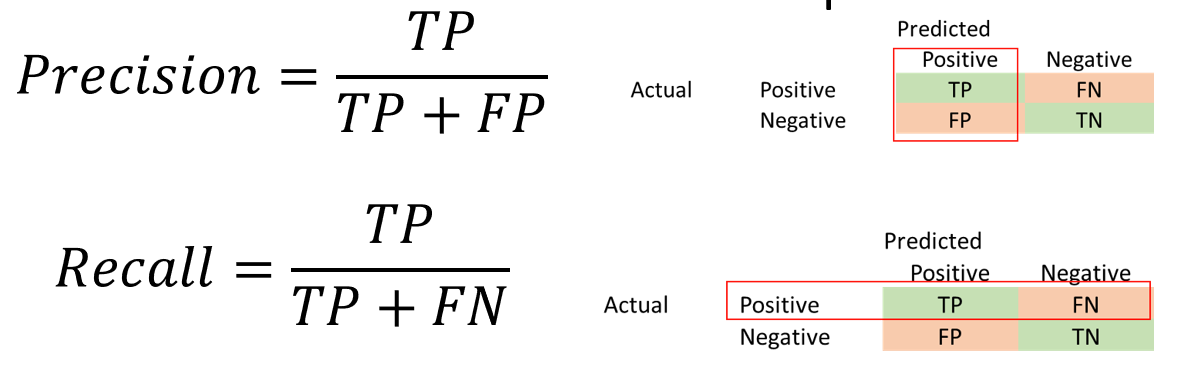  

We can look at our options using the ROC curve, but the ROC curve uses False Positive and True Positive rates (not precision and recall).  Roughly, we want a high True Positive rate (that minimizes FNs) and are okay if the False Positive rate goes up.  

Recall the formulae for TP and FP rates:  
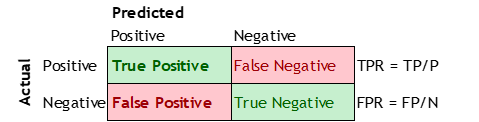

**This means we can play around with the threshold that decides what is marked as 'yes'.  Feel free to reduce this threshold on the next cell, and see if it helps you get better recall for category 1 (that may reduce accuracy, but that is okay).**  




In [28]:
# Set threshold for identifying class 1
threshold = 0.50


In [29]:
# Create predictions.  Note that predictions give us probabilities, not classes!
pred_prob = model_xgb.predict_proba(X_test)

# Convert probabilities to 1s and 0s based on threshold
pred = (pred_prob>threshold).astype(int)

pred = np.argmax(pred, axis = 1) # argmax converts the 2 probabilities (one for each class) into a single prob defined by threshold

# confusion matrix
cm = confusion_matrix(y_test, pred)
print ("Confusion Matrix : \n", cm)
 
# accuracy score of the model
print('Test accuracy = ', accuracy_score(y_test, pred))

Confusion Matrix : 
 [[19611  3154]
 [   19   860]]
Test accuracy =  0.8658010488918965


In [30]:
print(classification_report(y_true = y_test, y_pred = pred))

              precision    recall  f1-score   support

           0       1.00      0.86      0.93     22765
           1       0.21      0.98      0.35       879

    accuracy                           0.87     23644
   macro avg       0.61      0.92      0.64     23644
weighted avg       0.97      0.87      0.90     23644



In [31]:
# See what predicted probabilities look like
pred_prob

array([[9.9911231e-01, 8.8770344e-04],
       [9.9920166e-01, 7.9834304e-04],
       [9.9397397e-01, 6.0260263e-03],
       ...,
       [2.2774953e-01, 7.7225047e-01],
       [9.9877483e-01, 1.2251717e-03],
       [9.9842310e-01, 1.5769289e-03]], dtype=float32)

In [32]:
pred_prob = pred_prob[:,1]

### AUC and ROC calculation

In [33]:
# AUC calculation
from sklearn import metrics
metrics.roc_auc_score(y_test, pred_prob)

0.9370697338663552

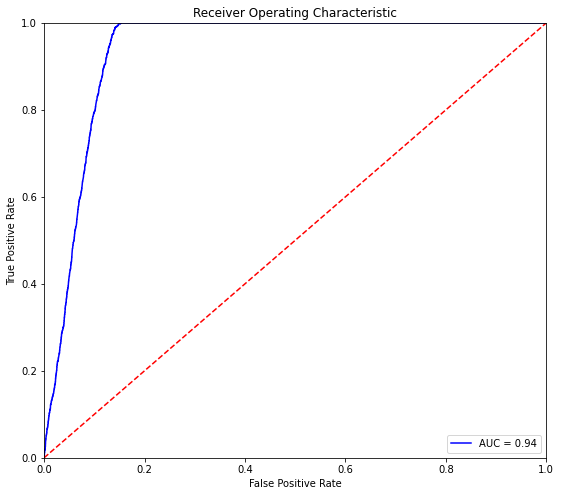

In [34]:
# Source for code below: https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python
fpr, tpr, thresholds = metrics.roc_curve(y_test, pred_prob)
roc_auc = metrics.auc(fpr, tpr)
plt.figure(figsize = (9,8))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [35]:
pd.DataFrame({'TPR': tpr, 'FPR': fpr, 'Threshold': thresholds}).sort_values(by = ['Threshold']).reset_index(drop=True)

,TPR,FPR,Threshold
0,1.000000,1.000000,0.000098
1,1.000000,0.999868,0.000153
2,1.000000,0.999693,0.000159
3,1.000000,0.999605,0.000172
4,1.000000,0.999121,0.000172
...,...,...,...
5749,0.003413,0.000351,0.991035
5750,0.003413,0.000176,0.993064
5751,0.000000,0.000176,0.993939
5752,0.000000,0.000044,0.997285


## Now try logistic regression

In [36]:
model = sm.Logit(y_train, X_train).fit(method='bfgs')
model.summary()

         Current function value: 0.229915
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


C:\Users\dhruv\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
C:\Users\dhruv\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 6880
Model:                          Logit   Df Residuals:                     6477
Method:                           MLE   Df Model:                          402
Date:                Thu, 02 Dec 2021   Pseudo R-squ.:                  0.6683
Time:                        19:35:38   Log-Likelihood:                -1581.8
converged:                      False   LL-Null:                       -4768.9
Covariance Type:            nonrobust   LLR p-value:                     0.000
===========================================================================================================================================================================================
                                                                                                                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Product_Bank account or service                                                                                             2.8458        nan        nan        nan         nan         nan
Product_Checking or savings account                                                                                        -3.8982        nan        nan        nan         nan         nan
Product_Consumer Loan                                                                                                       1.7158        nan        nan        nan         nan         nan
Product_Credit card                                                                                                         3.3286        nan        nan        nan         nan         nan
Product_Credit card or prepaid card                                                                                        -3.4974        nan        nan        nan         nan         nan
Product_Credit reporting                                                                                                    0.3291        nan        nan        nan         nan         nan
Product_Credit reporting, credit repair services, or other personal consumer reports                                       -2.2473        nan        nan        nan         nan         nan
Product_Debt collection                                                                                                     0.4525        nan        nan        nan         nan         nan
Product_Money transfer, virtual currency, or money service                                                                 -1.4585        nan        nan        nan         nan         nan
Product_Money transfers                                                                                                     0.5414        nan        nan        nan         nan         nan
Product_Mortgage                                                                                                            0.6401        nan        nan        nan         nan         nan
Product_Other financial service                                                                                             0.2178        nan        nan        nan         nan         nan
Product_Payday loan                                                                                                         0.0314        nan        nan        nan         nan         nan
Product_Payday loan, title loan, or personal loan                                                                          -0.5404        nan        nan        nan         nan         nan
Product_Prepaid card                         

#### Run the model on the test set, and build a confusion matrix  

**You can play with the threshold to get the right True Positive rate you desire!  The default generally is 0.50 but you can change it to lower values - eg, 0.2**   

In [37]:

# Set threshold for identifying class 1
threshold = 0.20

In [38]:
# Create predictions.  Note that predictions give us probabilities, not classes!
pred_prob = model.predict(X_test)

# Convert probabilities to 1s and 0s based on threshold
pred = (pred_prob>threshold).astype(int)
 
# confusion matrix
cm = confusion_matrix(y_test, pred)
print ("Confusion Matrix : \n", cm)
 
# accuracy score of the model
print('Test accuracy = ', accuracy_score(y_test, pred))

Confusion Matrix : 
 [[19451  3314]
 [    5   874]]
Test accuracy =  0.8596261207917442


In [39]:
cm = confusion_matrix(y_test, pred)
pd.DataFrame(cm, columns=['Predicted 0', 'Predicted 1'], index = ['Actual 0', 'Actual 1'])

,Predicted 0,Predicted 1
Actual 0,19451,3314
Actual 1,5,874


In [40]:
print(classification_report(y_true = y_test, y_pred = pred))

              precision    recall  f1-score   support

           0       1.00      0.85      0.92     22765
           1       0.21      0.99      0.34       879

    accuracy                           0.86     23644
   macro avg       0.60      0.92      0.63     23644
weighted avg       0.97      0.86      0.90     23644



In [41]:
# See what predicted probabilities look like
pred_prob

91974     0.000026
117220    0.000619
68306     0.026687
17656     0.856458
76579     0.000285
            ...   
113756    0.000056
91800     0.000188
1848      0.948673
72149     0.000190
54740     0.000123
Length: 23644, dtype: float64

<AxesSubplot:>

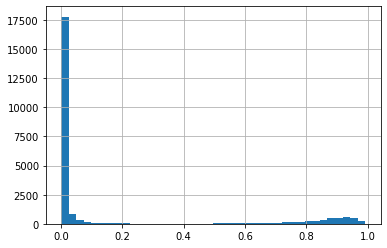

In [42]:
# A histogram of probabilities.  Why not?
pred_prob.hist(bins=40)

### AUC and ROC calculation

In [43]:
# AUC calculation
metrics.roc_auc_score(y_test, pred_prob)

0.9350551349833225

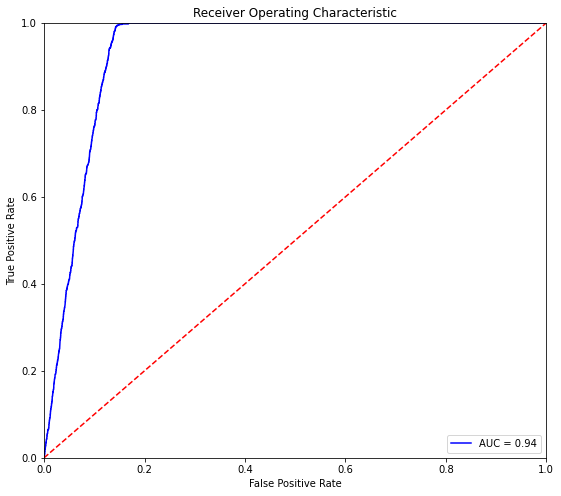

In [44]:
# Source for code below: https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python
fpr, tpr, thresholds = metrics.roc_curve(y_test, pred_prob)
roc_auc = metrics.auc(fpr, tpr)
plt.figure(figsize = (9,8))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()